# Лабораторная работа 1

## Задание 1

### Задание 1.1

Задана плотность распределения вероятностей некоторой случайной величины:  
$𝑓(𝑥) = (1/4𝜋) * (2 + cos 𝑥)* 𝐼(0 ≤ 𝑥 ≤ 2𝜋)$,
где 𝐼(𝑥 ∈ 𝐴) = 1, если 𝑥 ∈ 𝐴 и нуль иначе.  
  
Нужно сгенерировать выборку из данного распределения. На основе сгенерированной выборки проверить гипотезу согласия с заданным распределением.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest


def I(x: float):
    return np.logical_and(0 <= x, x <= 2 * np.pi)

# плотность распределения
def f(x):
    return (1 / (4 * np.pi)) * (2 + np.cos(x)) * I(x)

# теоретическая функция распределения
def F(x):
    return (1 / (4 * np.pi)) * (2 * x + np.sin(x)) * I(x)

In [2]:
def generate_sample(size):
    sample = []
    M = 3 / (4 * np.pi)
    # M = 0.4
    while len(sample) < size:
        x1 = np.random.uniform(0, 2 * np.pi)
        x2 = np.random.uniform(0, M)
        if x2 <= f(x1):
            sample.append(x1)
    return np.array(sample)

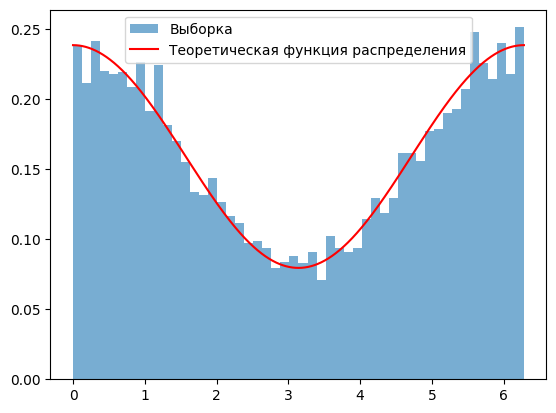

In [3]:
# генерация выборки
sample_size = 10000
sample = generate_sample(sample_size)

# график
plt.hist(sample, bins=50, density=True, alpha=0.6, label='Выборка')
x_vals = np.linspace(0, 2 * np.pi, 1000)
plt.plot(x_vals, f(x_vals), 'r-', label='Теоретическая функция распределения')
plt.legend()
plt.show()

In [4]:
# проверка гипотезы согласия
D, p_value = kstest(sample, F)

print(f"Статистика Колмогорова-Смирнова: D = {D:.10f}")
print(f"p-value: {p_value:.10f}")

Статистика Колмогорова-Смирнова: D = 0.0072181470
p-value: 0.6718868313


Значение p-value больше выбранного уровня значимости 0.05 (уровень доверия 95%). Гипотеза согласия не отвергается, и имеются веские основания полагать, что выборка соответствует заданному распределению.

### Задание 1.2

Пусть случайный вектор 𝑋 = (𝑋1, ..., 𝑋𝑛) имеет многомерное нормальное распределение N(𝜇, Σ) (вектор средних 𝜇 и матрица ковариаций Σ заданы).  
  
На основе сгенерированной выборки найти оценку матрицы ковариаций и проверить гипотезу о равенстве коэффициента корреляции 𝐶𝑜𝑟(𝑋𝑖
, 𝑋𝑗) (для фиксированных индексов 𝑖, 𝑗 = 1, ..., 𝑛) требуемому значению.

In [5]:
import numpy as np

# параметры распределения
a = np.array([1, 2, 3])  # вектор средних = матожидания
sigma = np.array([[1,   0.5,   0.25],
                  [0.5,   2,   0.75],
                  [0.25, 0.75, 3]]) # матрица ковариаций

# генерация выборки
sample_size = 1000
X = np.random.multivariate_normal(a, sigma, sample_size)

In [6]:
print(X)

[[0.57334095 1.22353101 1.93033301]
 [1.66835438 0.58146007 5.07705584]
 [1.28776333 1.66791573 2.41946231]
 ...
 [1.89738208 1.65303381 0.60225132]
 [2.03465689 3.76548476 1.51069893]
 [0.73546633 2.51779322 2.71150924]]


In [7]:
# оценка матрицы ковариаций
sigma_est = np.cov(X, rowvar=False)
print("оценка матрицы ковариаций:\n", sigma_est)

оценка матрицы ковариаций:
 [[0.96092164 0.5161465  0.22468642]
 [0.5161465  1.87882101 0.64236172]
 [0.22468642 0.64236172 2.85252376]]


In [8]:
from scipy.stats import norm

i, j = 122, 455
# требуемое значение коэффициента корреляции
rho_0 = 0.24

# выборочный коэффициент корреляции
r_ij = np.corrcoef(X[i, :], X[j, :], rowvar=False)[0, 1]

# Z-преобразование Фишера
def fisher_z_transform(r):
    return 0.5 * np.log((1 + r) / (1 - r))

z_r = fisher_z_transform(r_ij)
z_rho0 = fisher_z_transform(rho_0)

# статистика для проверки гипотезы
n = sample_size
z_stat = (z_r - z_rho0) / np.sqrt(1 / (n - 3))

# критическое значение для уровня значимости 5% (двусторонний тест)
alpha = 0.05
z_critical = norm.ppf(1 - alpha / 2)

print(f"Cor(X_{i+1}, X_{j+1}) = {r_ij:.4f}")
# проверка гипотезы
if abs(z_stat) > z_critical:
    print(f"Гипотеза отвергается: Cor(X_{i+1}, X_{j+1}) != {rho_0}")
else:
    print(f"Гипотеза не отвергается: Cor(X_{i+1}, X_{j+1}) = {rho_0}")

Cor(X_123, X_456) = 0.5798
Гипотеза отвергается: Cor(X_123, X_456) != 0.24


## Задание 2

Заданы координаты вершин двух треугольников (на плоскости). С помощью метода Монте-Карло вычислить площадь их пересечения.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


def point_in_triangle(p, A, B, C):
    # метод барицентрических координат.
    # p - координаты точки (x, y).
    # A - координаты первой вершины треугольника (x, y).
    # B - координаты второй вершины треугольника (x, y).
    # C - координаты третьей вершины треугольника (x, y).
    # возвращает true или false.

    # векторы, представляющие стороны треугольника относительно вершины A
    v0 = [C[0] - A[0], C[1] - A[1]]  # вектор AC
    v1 = [B[0] - A[0], B[1] - A[1]]  # вектор AB
    v2 = [p[0] - A[0], p[1] - A[1]]  # вектор AP (от A до точки p)

    # вычисляем скалярные произведения для барицентрических координат
    dot00 = np.dot(v0, v0)  # квадрат длины вектора AC
    dot01 = np.dot(v0, v1)  # скалярное произведение AC и AB
    dot02 = np.dot(v0, v2)  # скалярное произведение AC и AP
    dot11 = np.dot(v1, v1)  # квадрат длины вектора AB
    dot12 = np.dot(v1, v2)  # скалярное произведение AB и AP

    # вычисляем знаменатель для барицентрических координат
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)

    # вычисляем барицентрические координаты u и v
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom  # координата u
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom  # координата v

    # точка лежит внутри треугольника, если:
    # 1. u >= 0 (точка лежит по "правильную" сторону от стороны AB)
    # 2. v >= 0 (точка лежит по "правильную" сторону от стороны AC)
    # 3. u + v < 1 (точка лежит внутри треугольника, а не за его пределами)
    return (u >= 0) and (v >= 0) and (u + v < 1)

In [10]:
def monte_carlo_area_intersection(A, B, x_min, y_min, x_max, y_max):
    # параметры метода Монте-Карло
    N = 1000
    points_in_intersection = 0

    for _ in range(N):
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        p = (x, y)
        if point_in_triangle(p, A[0], A[1], A[2]) and point_in_triangle(p, B[0], B[1], B[2]):
            points_in_intersection += 1

    # оценка площади пересечения
    rectangle_area = (x_max - x_min) * (y_max - y_min)
    intersection_area = (points_in_intersection / N) * rectangle_area

    print(f"Площадь пересечения: {intersection_area:.4f}")

    # визуализация треугольников
    fig, ax = plt.subplots()
    ax.add_patch(Polygon(A, fill=None, edgecolor='blue', label='Треугольник A'))
    ax.add_patch(Polygon(B, fill=None, edgecolor='red', label='Треугольник B'))

    # визуализация случайных точек
    x_points = np.random.uniform(x_min, x_max, N)
    y_points = np.random.uniform(y_min, y_max, N)
    colors = ['green' if point_in_triangle((x, y), A[0], A[1], A[2]) and point_in_triangle((x, y), B[0], B[1], B[2]) else 'gray' for x, y in zip(x_points, y_points)]
    ax.scatter(x_points, y_points, c=colors, s=4, alpha=1.0)

    # настройка графика
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.legend()
    plt.show()

Площадь пересечения: 1.5600


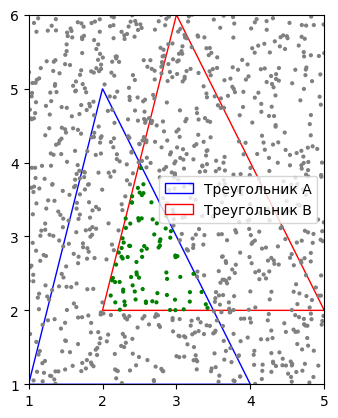

In [11]:
# координаты вершин треугольников
A = [(1, 1), (4, 1), (2, 5)]
B = [(2, 2), (5, 2), (3, 6)]

# ограничивающий прямоугольник
x_coords = [p[0] for p in A + B]
y_coords = [p[1] for p in A + B]
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

monte_carlo_area_intersection(A, B, x_min, y_min, x_max, y_max)

## Задание 3

Портфель составлен из ценных бумаг 𝑚 различных видов. Предполагается, что стоимость ценной бумаги вида 𝑖 = 1, ..., 𝑚 изменяется в соответствии с геометрическим броуновским движением:  
$$S_T^i=S_0^i e^{\left(\mu_i-\sigma_i^2 / 2\right) T+\sigma_i \sqrt{T} Z_i}, Z_i \sim \mathcal{N}(0,1)$$

Случайные процессы $S^i$, 𝑖 = 1, ..., 𝑚 предполагаются независимыми. Общая стоимость портфеля в момент времени 𝑡 равна  
$V_t=\sum_{i=1}^m n_i S_t^i$, где $n_i$ – число ценных бумаг вида 𝑖.

Обозначим разницу в стоимости портфеля $𝐿_𝑇 = 𝑉_0 − 𝑉_𝑇$. Требуется найти стоимостную меру риска (VaR - Value at Risk)  
$V a R_\alpha=\sup \left\{u \in \mathbb{R}: \mathbb{P}\left(L_T \geq u\right) \geq 1-\alpha\right\}$, где 1 − 𝛼 – уровень доверия

$S_T^i$ - цена в момент времени T

$S_0^i$ - начальная цена

$\mu_i$ - доходность

$\sigma_i$ - волатильность (дисперсия цены)

$Z_i$ - случайная величина с нормальным распределением

In [15]:
import numpy as np

# параметры портфеля
m = 3  # количество видов ценных бумаг
n = np.array([10, 20, 30])  # количество ценных бумаг каждого вида
S0 = np.array([100, 50, 80])  # начальные стоимости ценных бумаг
mu = np.array([0.05, 0.03, 0.04])  # ожидаемые доходности
sigma = np.array([0.2, 0.15, 0.25])  # волатильности
T = 1  # временной горизонт (1 год)

alpha = 0.05 # уровень доверия (1 - alpha)
N = 100000 # количество сценариев Монте-Карло

V0 = np.sum(n * S0) # начальная стоимость портфеля

# моделирование будущих стоимостей ценных бумаг и убытков
losses = np.zeros(N)
for i in range(N):
    Z = np.random.normal(0, 1, m) # генерация случайных величин Z_i ~ N(0, 1)
    ST = S0 * np.exp((mu - sigma**2 / 2) * T + sigma * np.sqrt(T) * Z) # моделирование будущих стоимостей S_T^i
    VT = np.sum(n * ST) # стоимость портфеля в момент T
    losses[i] = V0 - VT # убыток

# вычисление VaR_alpha
VaR_alpha = np.quantile(losses, 1 - alpha)
print(f"VaR_{alpha}: {VaR_alpha:.2f}")

VaR_0.05: 820.70


## Задание 4

В области 𝐴, представляющей собой бесконечный слой (на плоскости) вакуума толщиной 𝐷 м, было одновременно испущено 𝑁 +1 фотонов, где 𝑁 – случайная величина, имеющая распределение Пуассона с параметром 𝜆 = 2. Предполагается, что точки излучения расположены на одной прямой и их распределение по толщине 𝐷 равномерное, а распределение направлений излучения фотонов – изотропное. С каждой из двух сторон расположен детектор в виде бесконечной полосы. При попадании в детектор фотон поглощается. Детекторы включены в схему совпадений, которая срабатывает в том случае, если промежуток времени между попаданиями фотонов в детекторы не превышает ∆𝑡 = 3 · 10^−8 с. Скорость света в вакууме 𝐶 = 3 · 10^8 м/с. Вычислить вероятность того, что схема сработала.

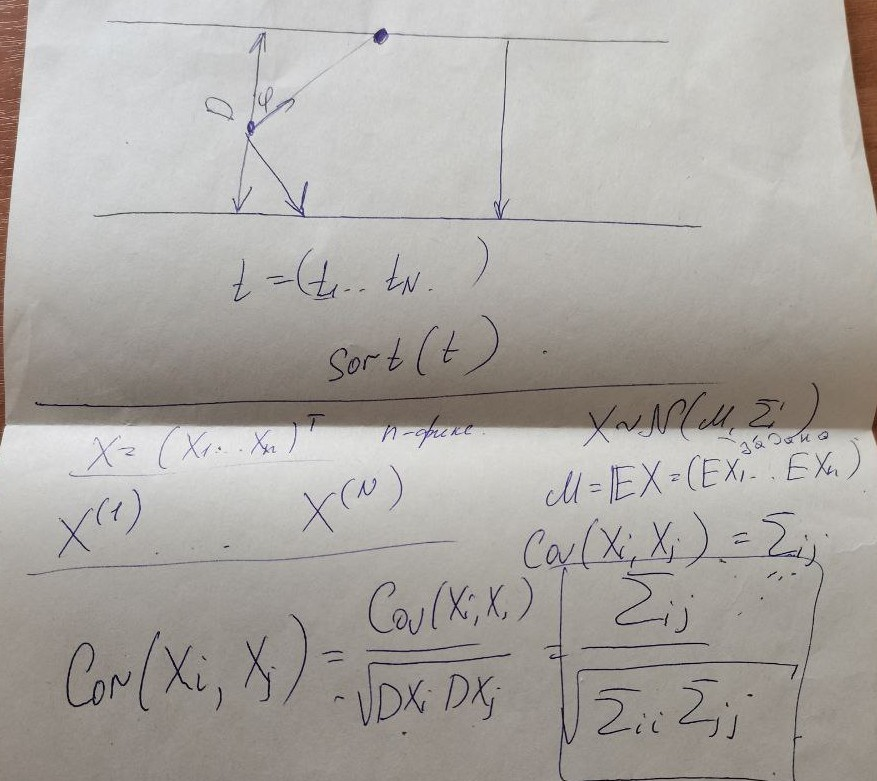

In [16]:
import numpy as np

# Параметры задачи
D = 1  # Толщина слоя (м)
C = 3e8  # Скорость света (м/с)
Delta_t = 3e-8  # Временной интервал для срабатывания схемы (с)
lambda_poisson = 2  # Параметр распределения Пуассона для количества фотонов
k = 10000 # Количество экспериментов (симуляций)
success_count = 0

for _ in range(k):
    N = np.random.poisson(lambda_poisson)
    total_photons = N + 1 
    x = np.random.uniform(0, D, total_photons) 
    theta = np.random.uniform(0, 2 * np.pi, total_photons)

    t = np.zeros(total_photons)
    for i in range(total_photons):
        if np.cos(theta[i]) > 0:
            # Фотон движется в сторону верхнего детектора (x = D)
            t[i] = (D - x[i]) / (C * np.cos(theta[i]))
        else:
            # Фотон движется в сторону нижнего детектора (x = 0)
            t[i] = x[i] / (C * np.abs(np.cos(theta[i])))

    # Проверка срабатывания схемы совпадений
    scheme_triggered = False 
    theta = sorted(theta)
    for i in range(0, total_photons - 1):
        # Проверяем, что фотоны попали в разные детекторы и разница во времени попадания не превышает Delta_t
        if np.abs(t[i] - t[i + 1]) <= Delta_t:
            scheme_triggered = True  # Схема сработала
            break
        if scheme_triggered:
            break 

    # Увеличиваем счетчик успешных срабатываний
    if scheme_triggered:
        success_count += 1

probability = success_count / k
print(f"Вероятность срабатывания схемы: {probability:.6f}")

Вероятность срабатывания схемы: 0.843400


## Задание 5

Реализовать алгоритм генерации точек, равномерно распределенных на поверхности геликоида:  
$$
\left\{
\begin{array}{l}
x = u \cos v, \\
y = u \sin v, \\
z = v
\end{array}
\right.
\quad 0 \leq u, v \leq 2 \pi
$$

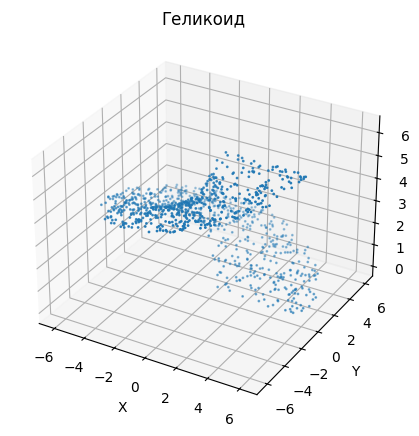

In [17]:
import numpy as np
import matplotlib.pyplot as plt


def generate_helicoid_points(n_points=1000):
    """
    Генерирует равномерно распределенные точки на поверхности геликоида
    
    Параметры:
    n_points (int): количество точек для генерации
    
    Возвращает:
    numpy.ndarray: массив точек [x, y, z]
    """
    # генерируем равномерно распределенные точки в параметрическом пространстве
    # используем преобразование для равномерного распределения на спирали
    u = np.sqrt(np.random.uniform(0, 1, n_points)) * (2 * np.pi) # радиальная координата (расстояние от оси z)
    v = np.random.uniform(0, 1, n_points) * (2 * np.pi) # угловая координата (угол поворота вокруг оси z)
    
    # Вычисляем координаты
    x = u * np.cos(v)
    y = u * np.sin(v)
    z = v
    
    # Собираем результат в единый массив
    points = np.column_stack((x, y, z))
    
    return points

def plot_helicoid(points):
    """
    Визуализирует полученные точки
    """
    fig = plt.figure(figsize=(5, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Рисуем точки
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
    
    # Настраиваем оси
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Геликоид')
    
    plt.show()

# Генерируем точки
points = generate_helicoid_points(1000)

# Визуализируем результат
plot_helicoid(points)